In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

import nltk
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
#nltk.download('stopwords')

import re
#nltk.download("averaged_perceptron_tagger")

import warnings
warnings.filterwarnings("ignore")

In [2]:
headline_data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True, orient='columns', encoding='utf-8')

In [3]:
headline_data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Data Exploration and Data Cleaning

In [4]:
data = headline_data.copy()

### Here we observe our data by checking the datatypes of the features

In [10]:
data.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


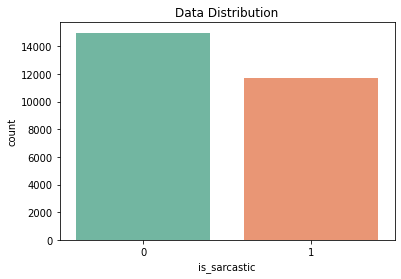

In [11]:
#check for the distribution of the dataset for the reponse variable in order to get the balance of the dataset

ax = sns.countplot(data['is_sarcastic'],  palette="Set2")
plt.title('Data Distribution');

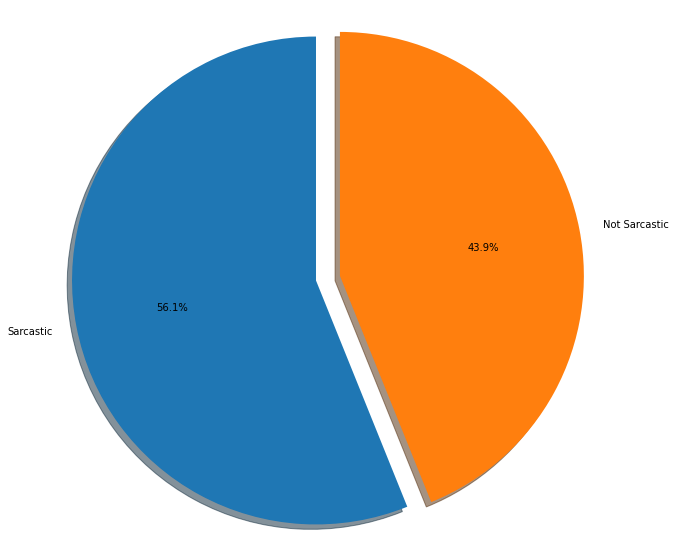

In [12]:
#Calculating the percentage of the sarcastic and non-sarcastic to get the overview of the labels

labels = ['Sarcastic', 'Not Sarcastic']

zeros_percent = (data['is_sarcastic'].value_counts()[0]/ data['is_sarcastic'].value_counts().sum())*100
ones_percent = (data['is_sarcastic'].value_counts()[1]/ data['is_sarcastic'].value_counts().sum())*100

sizes = [zeros_percent,ones_percent]
explode = (0, 0.1)
plt.figure(figsize=(10,10))
plt.pie(sizes, labels=labels, explode = explode, 
        autopct='%1.1f%%', shadow=True, startangle= 90, pctdistance=0.6)
plt.axis('equal')
plt.show()

In [13]:
#Check for null values into the dataset
print(data.isnull().sum())

article_link    0
headline        0
is_sarcastic    0
dtype: int64


In [14]:
#Calculate the length of sentences
data['source'] = data['article_link'].apply(lambda x: re.findall(r'\w+', x)[2])
data['len'] = data['headline'].apply(lambda x: len(x.split(" ")))
data.head()

,article_link,headline,is_sarcastic,source,len
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost,12
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion,14
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion,13
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11


In [15]:
#Dropping unneccesaary column not helpful for classification.

data = data.drop(['article_link'], axis=1)
data.head()

,headline,is_sarcastic,source,len
0,former versace store clerk sues over secret 'b...,0,huffingtonpost,12
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14
2,mom starting to fear son's web series closest ...,1,theonion,14
3,"boehner just wants wife to listen, not come up...",1,theonion,13
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11


<AxesSubplot:xlabel='source', ylabel='count'>

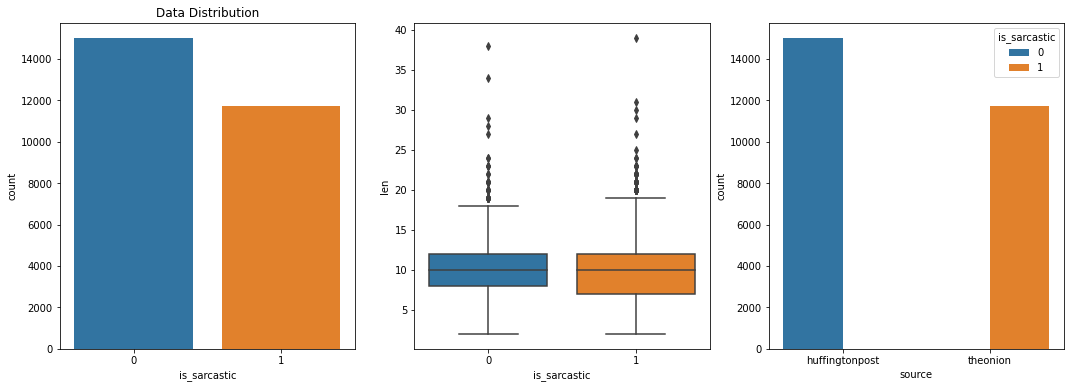

In [16]:
plt.subplots(figsize= (18,6))
plt.subplot(1,3,1)
sns.countplot('is_sarcastic',data = data)
plt.title('Data Distribution');
plt.subplot(1,3,2)
sns.boxplot(y = 'len',x = 'is_sarcastic',data = data)
plt.subplot(1,3,3)
sns.countplot('source',hue= 'is_sarcastic',data = data)

In [17]:
#Displaying the sentence having the maximum length of words.
data['len'].max()

39

In [18]:
data[data['len']==39]

,headline,is_sarcastic,source,len
15247,"elmore leonard, modern prose master, noted for...",1,theonion,39


In [19]:
#Visualising the sentences within the length of 20
for i,headline in enumerate (data['headline'], 1):
    if i > 20:
        break
    else:
        print(i, headline)

1 former versace store clerk sues over secret 'black code' for minority shoppers
2 the 'roseanne' revival catches up to our thorny political mood, for better and worse
3 mom starting to fear son's web series closest thing she will have to grandchild
4 boehner just wants wife to listen, not come up with alternative debt-reduction ideas
5 j.k. rowling wishes snape happy birthday in the most magical way
6 advancing the world's women
7 the fascinating case for eating lab-grown meat
8 this ceo will send your kids to school, if you work for his company
9 top snake handler leaves sinking huckabee campaign
10 friday's morning email: inside trump's presser for the ages
11 airline passengers tackle man who rushes cockpit in bomb threat
12 facebook reportedly working on healthcare features and apps
13 north korea praises trump and urges us voters to reject 'dull hillary'
14 actually, cnn's jeffrey lord has been 'indefensible' for a while
15 barcelona holds huge protest in support of refugees
16 n

In [20]:
#Calculating the frequency of word length and plotting the histogram of it.
data_length = data['len'].value_counts().reset_index()
data_length.rename(columns={'index': 'length_word', 'len':'frequency'}, inplace = True)
data_length.head()

,length_word,frequency
0,10,3484
1,9,3300
2,11,3196
3,8,2857
4,12,2646


<BarContainer object of 32 artists>

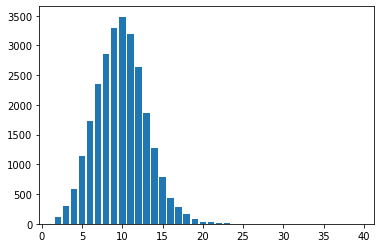

In [21]:
import matplotlib.pyplot as plt
plt.bar(data_length['length_word'], data_length['frequency'])

We observe a normal distribution here and the sentences having length count more than 20 is very less, so we can prune them easily as they will not be needed

In [22]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [23]:
data1 = headline_data.copy()

In [24]:
# Relacing special symbols and digits in headline column
# re stands for Regular Expression
data1['headline'] = data1['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))

In [25]:
def text_cleaning(data):
    data = data.apply(lambda x: x.strip().lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    
    data = data.apply(lambda x : word_tokenize(x))
    data = data.apply(lambda x: [word for word in x if word not in stop_words])
    
    
    lemmatizer = WordNetLemmatizer()
    data = data.apply(lambda x: [lemmatizer.lemmatize(word, pos ='v') for word in x])

    return data

In [26]:
data1["headline"] = text_cleaning(data1["headline"])
data1 = data1[data1["headline"].apply(lambda x: len(x)>0)]

In [27]:
data1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,"[former, versace, store, clerk, sue, secret, b...",0
1,https://www.huffingtonpost.com/entry/roseanne-...,"[roseanne, revival, catch, thorny, political, ...",0
2,https://local.theonion.com/mom-starting-to-fea...,"[mom, start, fear, son, web, series, closest, ...",1
3,https://politics.theonion.com/boehner-just-wan...,"[boehner, want, wife, listen, come, alternativ...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,"[j, k, rowling, wish, snape, happy, birthday, ...",0


In [28]:
data1["words"] = data1["headline"].apply(lambda x: len(x))
data1["characters"] = data1["headline"].apply(lambda x: len("".join(x)))

In [29]:
data1.head()

,article_link,headline,is_sarcastic,words,characters
0,https://www.huffingtonpost.com/entry/versace-b...,"[former, versace, store, clerk, sue, secret, b...",0,10,57
1,https://www.huffingtonpost.com/entry/roseanne-...,"[roseanne, revival, catch, thorny, political, ...",0,8,50
2,https://local.theonion.com/mom-starting-to-fea...,"[mom, start, fear, son, web, series, closest, ...",1,9,46
3,https://politics.theonion.com/boehner-just-wan...,"[boehner, want, wife, listen, come, alternativ...",1,9,54
4,https://www.huffingtonpost.com/entry/jk-rowlin...,"[j, k, rowling, wish, snape, happy, birthday, ...",0,9,41


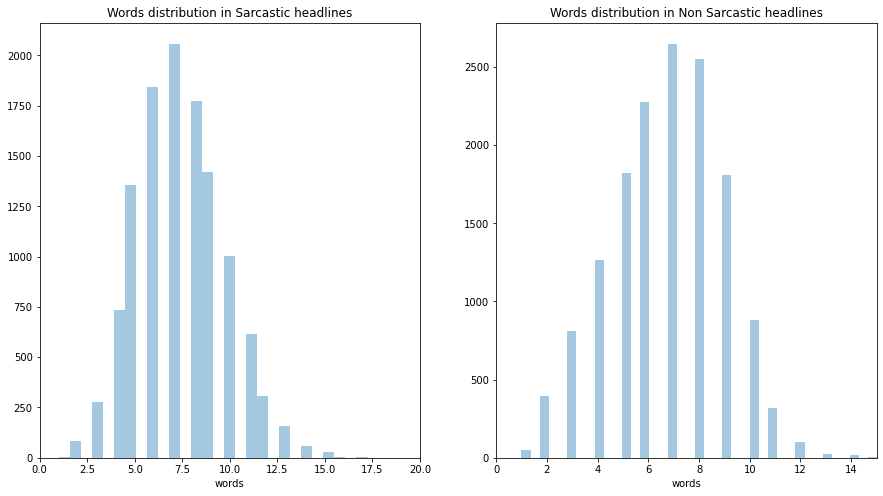

In [30]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.xlim(0, 20)
sns.distplot(data1[data1.is_sarcastic==1]["words"], kde=False)
plt.title("Words distribution in Sarcastic headlines")
plt.grid(False)

plt.subplot(1,2,2)
plt.xlim(0, 15)
sns.distplot(data1[data1.is_sarcastic==0]["words"], kde=False)
plt.title("Words distribution in Non Sarcastic headlines")

plt.grid(False)
plt.show()

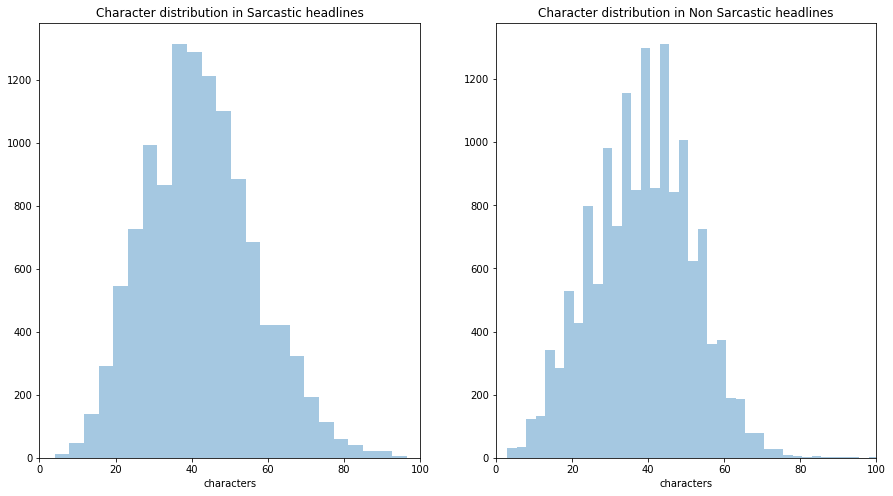

In [31]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.xlim(0, 100)
sns.distplot(data1[data1.is_sarcastic==1]["characters"], kde=False)
plt.title("Character distribution in Sarcastic headlines")
plt.grid(False)

plt.subplot(1,2,2)
plt.xlim(0, 100)
sns.distplot(data1[data1.is_sarcastic==0]["characters"], kde=False)
plt.title("Character distribution in Non Sarcastic headlines")

plt.grid(False)
plt.show()

In [32]:
data.head()

,headline,is_sarcastic,source,len
0,former versace store clerk sues over secret 'b...,0,huffingtonpost,12
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14
2,mom starting to fear son's web series closest ...,1,theonion,14
3,"boehner just wants wife to listen, not come up...",1,theonion,13
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11


In [33]:
import spacy
nlp = spacy.load("en_core_web_sm")
### Feature generation for better understanding
def get_ents(headline_text):
    document=nlp(headline_text)
    return len(document.ents)

def get_tokens(headline_text):
    document=nlp(headline_text)
    return len(document)

def get_sents(headline_text):
    document=nlp(headline_text)
    return len(list(document.sents))

In [34]:
data['ents_name'] = data['headline'].apply(get_ents)

In [35]:
data['tokens_num'] = data['headline'].apply(get_tokens)

In [36]:
data['sents_num'] = data['headline'].apply(get_sents)

In [37]:
data.head()

,headline,is_sarcastic,source,len,ents_name,tokens_num,sents_num
0,former versace store clerk sues over secret 'b...,0,huffingtonpost,12,0,14,1
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14,0,17,1
2,mom starting to fear son's web series closest ...,1,theonion,14,0,15,1
3,"boehner just wants wife to listen, not come up...",1,theonion,13,0,16,1
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11,0,12,2


<AxesSubplot:xlabel='sents_num', ylabel='count'>

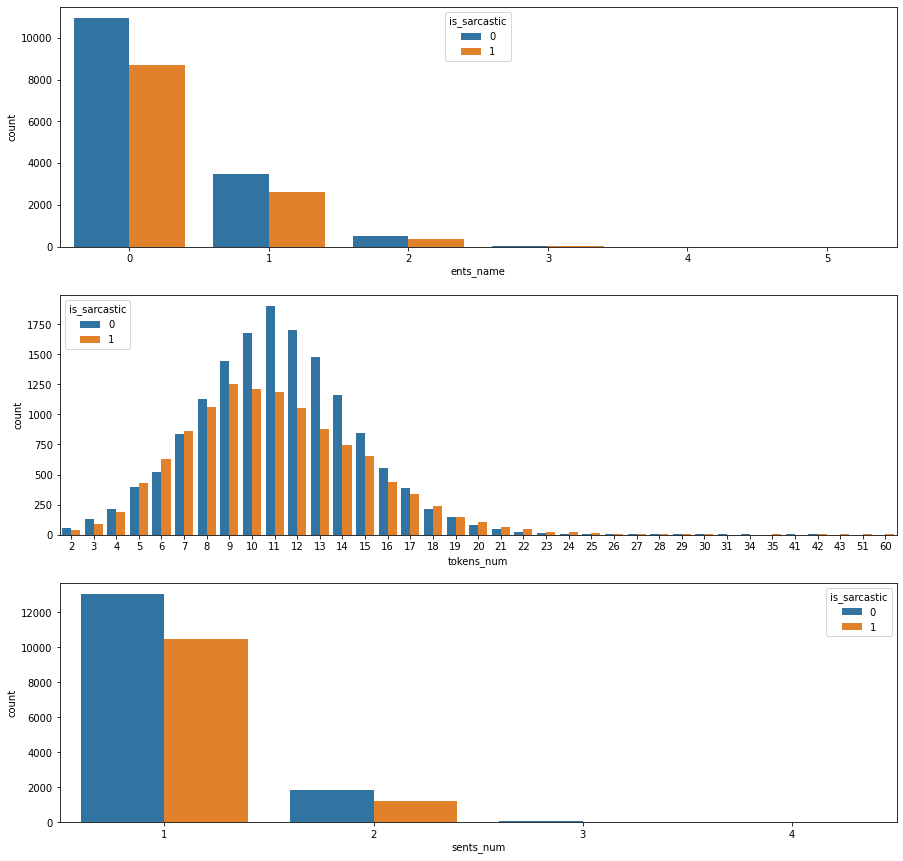

In [38]:
ffig,(ax,ax1,ax2)=plt.subplots(nrows=3,ncols=1,figsize=(15,15))
sns.countplot(x='ents_name',data=data,hue='is_sarcastic',ax=ax)
sns.countplot(x='tokens_num',data=data,hue='is_sarcastic',ax=ax1)
sns.countplot(x='sents_num',data=data,hue='is_sarcastic',ax=ax2)

## Data Pre-Processing

## Text Normalization

In [39]:
#STEP 1 : Remove Numbers and Punctuations using Regular Expressions

In [40]:
#sample to check working of re.sub function
mystring = "hello's world"
re.sub('[^A-Za-z ]+', '', mystring)

'hellos world'

In [41]:
#lambda to clean data of punctuation and numbers
def clean_data(x):
    return re.sub('[^A-Za-z ]+', '', x)

data['clean_hd'] = data["headline"].apply(clean_data)

In [42]:
data.head()

,headline,is_sarcastic,source,len,ents_name,tokens_num,sents_num,clean_hd
0,former versace store clerk sues over secret 'b...,0,huffingtonpost,12,0,14,1,former versace store clerk sues over secret bl...
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14,0,17,1,the roseanne revival catches up to our thorny ...
2,mom starting to fear son's web series closest ...,1,theonion,14,0,15,1,mom starting to fear sons web series closest t...
3,"boehner just wants wife to listen, not come up...",1,theonion,13,0,16,1,boehner just wants wife to listen not come up ...
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11,0,12,2,jk rowling wishes snape happy birthday in the ...


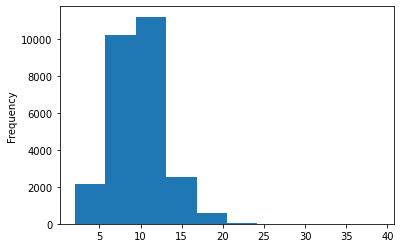

In [43]:
data['len'].plot(kind='hist')
plt.show()

In [44]:
# removing those headline whose length is less than 20
print('shape before preprocessing ',data.shape)
data = data[data['len'] < 20]
print('shape after preprocessing ',data.shape)
data.head()

shape before preprocessing  (26709, 8)
shape after preprocessing  (26606, 8)


,headline,is_sarcastic,source,len,ents_name,tokens_num,sents_num,clean_hd
0,former versace store clerk sues over secret 'b...,0,huffingtonpost,12,0,14,1,former versace store clerk sues over secret bl...
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14,0,17,1,the roseanne revival catches up to our thorny ...
2,mom starting to fear son's web series closest ...,1,theonion,14,0,15,1,mom starting to fear sons web series closest t...
3,"boehner just wants wife to listen, not come up...",1,theonion,13,0,16,1,boehner just wants wife to listen not come up ...
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11,0,12,2,jk rowling wishes snape happy birthday in the ...


In [45]:
# Step 2: Tokenization process
def tokenize_data(x):
    return x.split(" ")

data["tokens"] = data["clean_hd"].apply(tokenize_data)
data.head()

,headline,is_sarcastic,source,len,ents_name,tokens_num,sents_num,clean_hd,tokens
0,former versace store clerk sues over secret 'b...,0,huffingtonpost,12,0,14,1,former versace store clerk sues over secret bl...,"[former, versace, store, clerk, sues, over, se..."
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14,0,17,1,the roseanne revival catches up to our thorny ...,"[the, roseanne, revival, catches, up, to, our,..."
2,mom starting to fear son's web series closest ...,1,theonion,14,0,15,1,mom starting to fear sons web series closest t...,"[mom, starting, to, fear, sons, web, series, c..."
3,"boehner just wants wife to listen, not come up...",1,theonion,13,0,16,1,boehner just wants wife to listen not come up ...,"[boehner, just, wants, wife, to, listen, not, ..."
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11,0,12,2,jk rowling wishes snape happy birthday in the ...,"[jk, rowling, wishes, snape, happy, birthday, ..."


In [46]:
#Step 3: Parts of Speech Tagging to whole sentence

def calc_pos(x):
    tokens = x.split(" ")
    try:
        tagged_sent = nltk.pos_tag(tokens)
    except:
        tagged_sent = ["Can not Pos"]
  
    return tagged_sent

In [47]:
data_sar = data[data["is_sarcastic"] == 1]
data_non_sar = data[data["is_sarcastic"]==0]

In [48]:
data_sar["pos"] = data_sar["clean_hd"].apply(calc_pos)
data_non_sar["pos"] = data_non_sar["clean_hd"].apply(calc_pos)

In [49]:
data_sar.head()

,headline,is_sarcastic,source,len,ents_name,tokens_num,sents_num,clean_hd,tokens,pos
2,mom starting to fear son's web series closest ...,1,theonion,14,0,15,1,mom starting to fear sons web series closest t...,"[mom, starting, to, fear, sons, web, series, c...","[(mom, NN), (starting, VBG), (to, TO), (fear, ..."
3,"boehner just wants wife to listen, not come up...",1,theonion,13,0,16,1,boehner just wants wife to listen not come up ...,"[boehner, just, wants, wife, to, listen, not, ...","[(boehner, NN), (just, RB), (wants, VBZ), (wif..."
8,top snake handler leaves sinking huckabee camp...,1,theonion,7,0,7,1,top snake handler leaves sinking huckabee camp...,"[top, snake, handler, leaves, sinking, huckabe...","[(top, JJ), (snake, NN), (handler, NN), (leave..."
15,nuclear bomb detonates during rehearsal for 's...,1,theonion,8,0,12,2,nuclear bomb detonates during rehearsal for sp...,"[nuclear, bomb, detonates, during, rehearsal, ...","[(nuclear, JJ), (bomb, NN), (detonates, NNS), ..."
16,cosby lawyer asks why accusers didn't come for...,1,theonion,16,1,17,1,cosby lawyer asks why accusers didnt come forw...,"[cosby, lawyer, asks, why, accusers, didnt, co...","[(cosby, NN), (lawyer, NN), (asks, VBZ), (why,..."


In [50]:
#Calculate the total number of each type of POS and observe the distribution over the sentences

In [51]:
sarc_count ={}
non_sarc_count = {}

def pos_dict(x):
    try:
        pos_dict = dict(x)
    except:
        pos_dict = {}
    for k,v in pos_dict.items():
        if v in sarc_count:
            sarc_count[v]+=1
        else:
            sarc_count[v] = 1
    
    return pos_dict
   
def pos_dict_no_sarc(x):
    try:
        pos_dict = dict(x)
    except:
        pos_dict = {}
    for k,v in pos_dict.items():
        if v in non_sarc_count:
            non_sarc_count[v]+=1
        else:
            non_sarc_count[v] = 1
    
    return pos_dict

In [52]:
d1 = data_sar["pos"].apply(pos_dict)
d2 = data_non_sar["pos"].apply(pos_dict_no_sarc)

In [53]:
type(data_sar["pos"])

pandas.core.series.Series

In [54]:
data_sar.head()

,headline,is_sarcastic,source,len,ents_name,tokens_num,sents_num,clean_hd,tokens,pos
2,mom starting to fear son's web series closest ...,1,theonion,14,0,15,1,mom starting to fear sons web series closest t...,"[mom, starting, to, fear, sons, web, series, c...","[(mom, NN), (starting, VBG), (to, TO), (fear, ..."
3,"boehner just wants wife to listen, not come up...",1,theonion,13,0,16,1,boehner just wants wife to listen not come up ...,"[boehner, just, wants, wife, to, listen, not, ...","[(boehner, NN), (just, RB), (wants, VBZ), (wif..."
8,top snake handler leaves sinking huckabee camp...,1,theonion,7,0,7,1,top snake handler leaves sinking huckabee camp...,"[top, snake, handler, leaves, sinking, huckabe...","[(top, JJ), (snake, NN), (handler, NN), (leave..."
15,nuclear bomb detonates during rehearsal for 's...,1,theonion,8,0,12,2,nuclear bomb detonates during rehearsal for sp...,"[nuclear, bomb, detonates, during, rehearsal, ...","[(nuclear, JJ), (bomb, NN), (detonates, NNS), ..."
16,cosby lawyer asks why accusers didn't come for...,1,theonion,16,1,17,1,cosby lawyer asks why accusers didnt come forw...,"[cosby, lawyer, asks, why, accusers, didnt, co...","[(cosby, NN), (lawyer, NN), (asks, VBZ), (why,..."


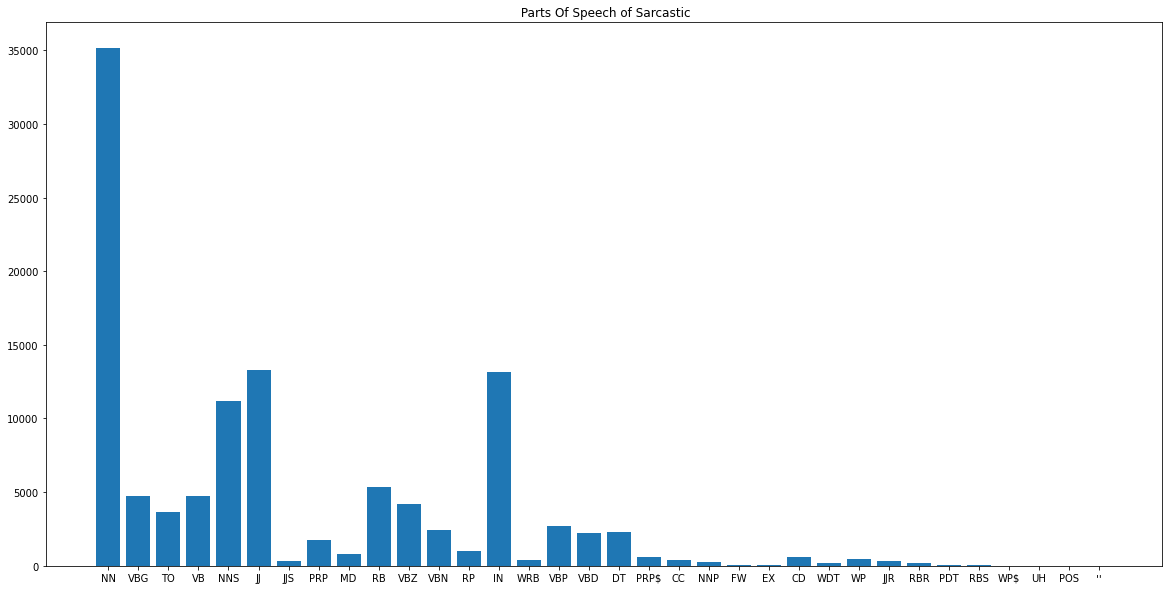

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
plt.bar(range(len(sarc_count)), list(sarc_count.values()), align='center')
plt.xticks(range(len(sarc_count)), list(sarc_count.keys()))

plt.title(" Parts Of Speech of Sarcastic")
plt.show()

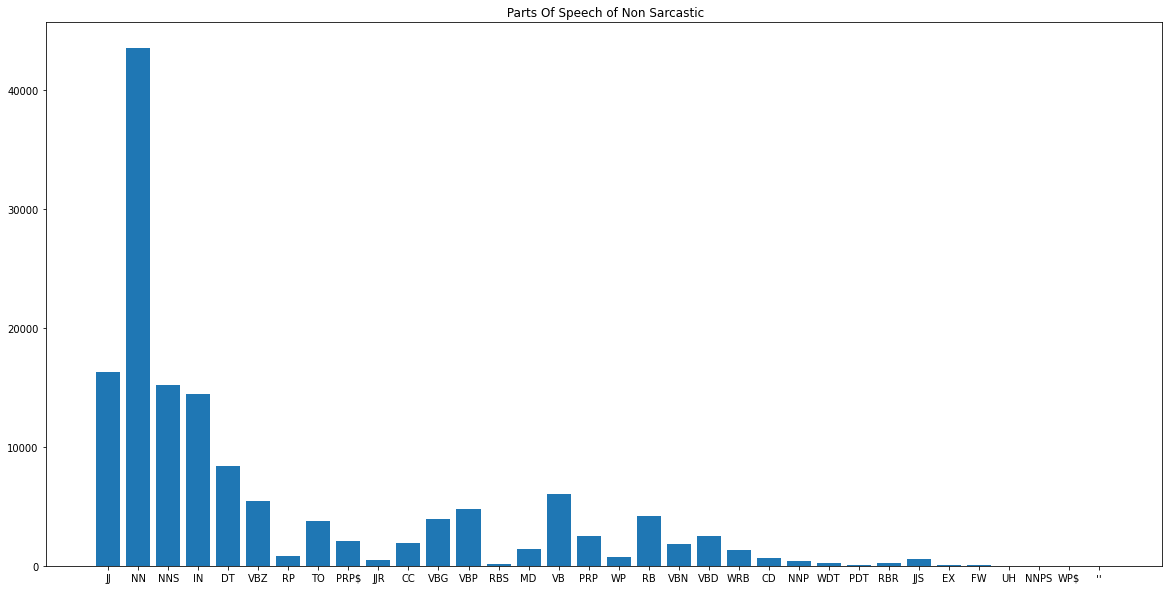

In [56]:
fig = plt.figure(figsize=(20,10))
plt.bar(*zip(*non_sarc_count.items()), align = 'center')
plt.title(" Parts Of Speech of Non Sarcastic")
plt.show()

We observe that most of the sarcastic words are nouns and verbs. They are used frequently and hence we lemmetize them.

In [57]:
# Step 4: Lemmetization

lemm = WordNetLemmatizer()


def lemmat(x):
    try:
        x = x.split(" ")
        temp = []
        for i in x:
              temp.append(lemm.lemmatize(i))
        return temp
    except:
        return ["could not perform op"]

In [58]:
data_sar["lemmatizer"] = data_sar["clean_hd"].apply(lemmat)

In [59]:
data_sar.head()

,headline,is_sarcastic,source,len,ents_name,tokens_num,sents_num,clean_hd,tokens,pos,lemmatizer
2,mom starting to fear son's web series closest ...,1,theonion,14,0,15,1,mom starting to fear sons web series closest t...,"[mom, starting, to, fear, sons, web, series, c...","[(mom, NN), (starting, VBG), (to, TO), (fear, ...","[mom, starting, to, fear, son, web, series, cl..."
3,"boehner just wants wife to listen, not come up...",1,theonion,13,0,16,1,boehner just wants wife to listen not come up ...,"[boehner, just, wants, wife, to, listen, not, ...","[(boehner, NN), (just, RB), (wants, VBZ), (wif...","[boehner, just, want, wife, to, listen, not, c..."
8,top snake handler leaves sinking huckabee camp...,1,theonion,7,0,7,1,top snake handler leaves sinking huckabee camp...,"[top, snake, handler, leaves, sinking, huckabe...","[(top, JJ), (snake, NN), (handler, NN), (leave...","[top, snake, handler, leaf, sinking, huckabee,..."
15,nuclear bomb detonates during rehearsal for 's...,1,theonion,8,0,12,2,nuclear bomb detonates during rehearsal for sp...,"[nuclear, bomb, detonates, during, rehearsal, ...","[(nuclear, JJ), (bomb, NN), (detonates, NNS), ...","[nuclear, bomb, detonates, during, rehearsal, ..."
16,cosby lawyer asks why accusers didn't come for...,1,theonion,16,1,17,1,cosby lawyer asks why accusers didnt come forw...,"[cosby, lawyer, asks, why, accusers, didnt, co...","[(cosby, NN), (lawyer, NN), (asks, VBZ), (why,...","[cosby, lawyer, asks, why, accuser, didnt, com..."


In [60]:
#Step 5: Removal of Stop Words
data['headline_new'] = data['headline'].apply(lambda x: re.sub('[^a-zA-Z]','  ',x))

In [61]:
noise_list = nltk.corpus.stopwords.words('english')

In [62]:
data['headline_new'] = data['headline_new'].apply(lambda x: [i for i in x.split() if i not in noise_list])

In [63]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

In [64]:
data['headline_new'] = data['headline_new'].apply(lambda x: [lem.lemmatize(i,'v') for i in x])

In [65]:
data['headline_new'] = data['headline_new'].apply(lambda x: [i.lower() for i in x])

In [66]:
#creating lemmatized and stopped sentences
def join_lammatize(x):
    return " ".join(x)

data["lemmat"] = data["headline_new"].apply(join_lammatize)

In [67]:
#stopper lambda:
stops = set(stopwords.words('english'))

def stopper_lambda(x):
 
    words = x.split(" ")
    temp = []
    for word in words:
        if word not in stops:
            temp.append(word)
    return " ".join(temp)

In [68]:
data["stopped"] = data["clean_hd"].apply(stopper_lambda)

In [69]:
#explaination of columns containing training data: 

#headline : raw data
#clean_hd : removed punctuations
#lemmat: lemmatized sentences
#stopped : Removed stopwords
data.head()

,headline,is_sarcastic,source,len,ents_name,tokens_num,sents_num,clean_hd,tokens,headline_new,lemmat,stopped
0,former versace store clerk sues over secret 'b...,0,huffingtonpost,12,0,14,1,former versace store clerk sues over secret bl...,"[former, versace, store, clerk, sues, over, se...","[former, versace, store, clerk, sue, secret, b...",former versace store clerk sue secret black co...,former versace store clerk sues secret black c...
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14,0,17,1,the roseanne revival catches up to our thorny ...,"[the, roseanne, revival, catches, up, to, our,...","[roseanne, revival, catch, thorny, political, ...",roseanne revival catch thorny political mood b...,roseanne revival catches thorny political mood...
2,mom starting to fear son's web series closest ...,1,theonion,14,0,15,1,mom starting to fear sons web series closest t...,"[mom, starting, to, fear, sons, web, series, c...","[mom, start, fear, son, web, series, closest, ...",mom start fear son web series closest thing gr...,mom starting fear sons web series closest thin...
3,"boehner just wants wife to listen, not come up...",1,theonion,13,0,16,1,boehner just wants wife to listen not come up ...,"[boehner, just, wants, wife, to, listen, not, ...","[boehner, want, wife, listen, come, alternativ...",boehner want wife listen come alternative debt...,boehner wants wife listen come alternative deb...
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11,0,12,2,jk rowling wishes snape happy birthday in the ...,"[jk, rowling, wishes, snape, happy, birthday, ...","[j, k, rowling, wish, snape, happy, birthday, ...",j k rowling wish snape happy birthday magical way,jk rowling wishes snape happy birthday magical...


In [70]:
clean_hd = 27539
lemmat = 20057
stopped = 27404
headline = 29549

plot_unique_dict = {"without punctuation":clean_hd, "Lemmatized": lemmat, "Stopped" : stopped , "Raw data":headline}

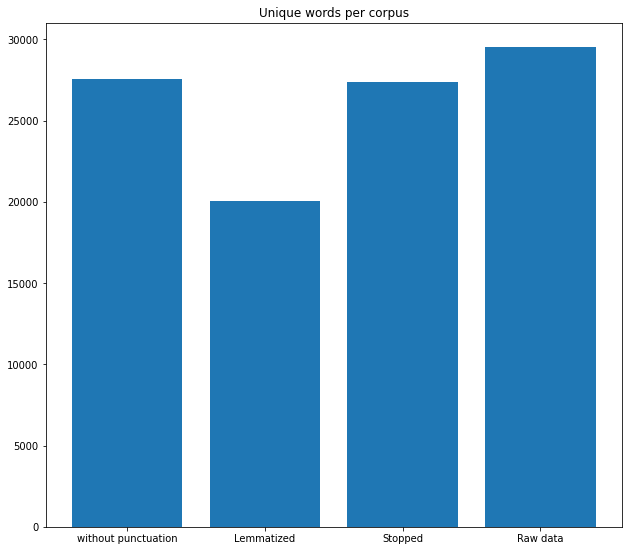

In [71]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))

ax1.set_title("Unique words per corpus")
plt.bar(range(len(plot_unique_dict)), list(plot_unique_dict.values()), align='center')
plt.xticks(range(len(plot_unique_dict)), list(plot_unique_dict.keys()))
plt.show()

In [72]:
#Saving the cleaned data
data.to_csv("Pre_Processed File.csv")